In [16]:
import os

os.environ["MKL_NUM_THREADS"]="1"
os.environ["NUMEXPR_NUM_THREADS"]="1"
os.environ["OMP_NUM_THREADS"]="1"

import sys

import pytorch_lightning as pl
from omegaconf import DictConfig, OmegaConf
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger
from torch.utils.data import random_split
from torch_geometric.data import DataLoader

from spatial.merfish_dataset import FilteredMerfishDataset, MerfishDataset
from spatial.models.monet_ae import MonetAutoencoder2D, TrivialAutoencoder, MonetDense
from spatial.train import train
from spatial.predict import test

In [17]:
test = MerfishDataset("../data")

In [18]:
test[0]

Data(anid=[1], bregma=[1], edge_index=[2, 1628], pos=[407, 2], x=[407, 155], y=[407, 2])

In [19]:
import torch

responses = None
for i in range(len(test)):
    if responses is None:
        responses = test[i].x[:, test.response_genes]
    else:
        responses = torch.cat((responses, test[i].x[:,test.response_genes]), axis=0)

In [20]:
test[i]

Data(anid=[1], bregma=[1], edge_index=[2, 1356], pos=[339, 2], x=[339, 155], y=[339, 2])

In [25]:
import matplotlib.pyplot as plt
import numpy as np

AttributeError: 'MerfishDataset' object has no attribute 'responses'

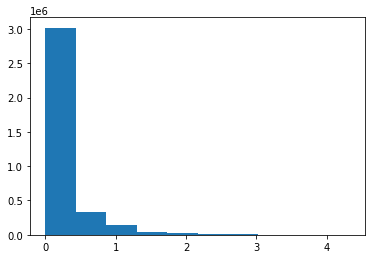

In [22]:
for i in range(responses.shape[1]):
    plt.figure()
    plt.hist(np.array(responses[:, i]), bins=10)
    plt.title(f"Response Gene #{test.responses[i]}")
    plt.show()

In [28]:
test.response_genes.index(93)

52

In [29]:
import pandas as pd

data = pd.read_csv("../data/raw/merfish.csv")

In [30]:
data = data.drop(["Blank_1", "Blank_2", "Blank_3", "Blank_4", "Blank_5", "Fos"], axis=1)
data = data.iloc[:, 9:]

In [36]:
data.columns[93], data.columns[151], data.columns[116]

('Pak3', 'Th', 'Slc17a8')

In [32]:
data.iloc[:, test.response_genes].columns

Index(['Ace2', 'Aldh1l1', 'Amigo2', 'Ano3', 'Aqp4', 'Ar', 'Arhgap36', 'Baiap2',
       'Ccnd2', 'Cd24a', 'Cdkn1a', 'Cenpe', 'Chat', 'Coch', 'Col25a1', 'Cplx3',
       'Cpne5', 'Creb3l1', 'Cspg5', 'Cyp19a1', 'Cyp26a1', 'Dgkk', 'Ebf3',
       'Egr2', 'Ermn', 'Esr1', 'Etv1', 'Fbxw13', 'Fezf1', 'Gbx2', 'Gda', 'Gem',
       'Gjc3', 'Greb1', 'Irs4', 'Isl1', 'Klf4', 'Krt90', 'Lmod1', 'Man1a',
       'Mki67', 'Mlc1', 'Myh11', 'Ndnf', 'Ndrg1', 'Necab1', 'Nos1', 'Npas1',
       'Nup62cl', 'Omp', 'Onecut2', 'Opalin', 'Pak3', 'Pcdh11x', 'Pgr',
       'Plin3', 'Pou3f2', 'Rgs2', 'Rgs5', 'Rnd3', 'Scgn', 'Serpinb1b', 'Sgk1',
       'Slc15a3', 'Slc17a6', 'Slc17a8', 'Slco1a4', 'Sox4', 'Sox6', 'Sox8',
       'Sp9', 'Synpr', 'Syt2', 'Syt4', 'Sytl4', 'Tiparp', 'Tmem108', 'Traf4',
       'Ttn', 'Ttyh2', 'Mbp', 'Nnat', 'Sln', 'Th'],
      dtype='object')

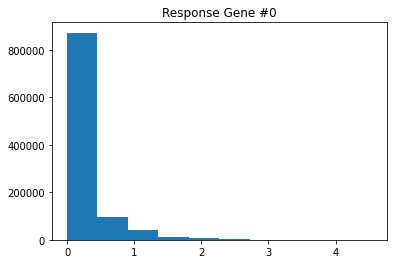

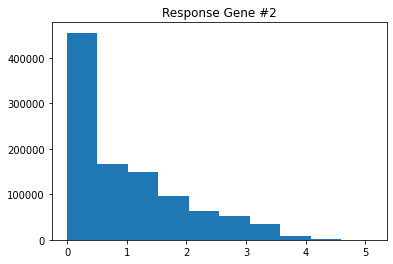

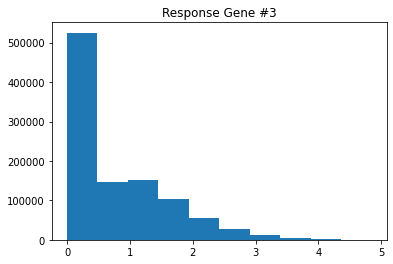

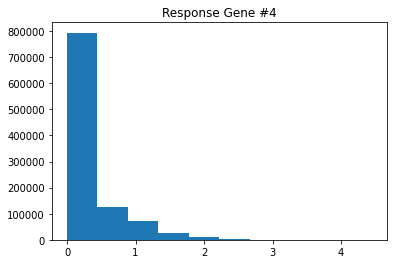

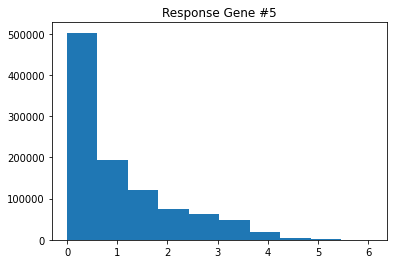

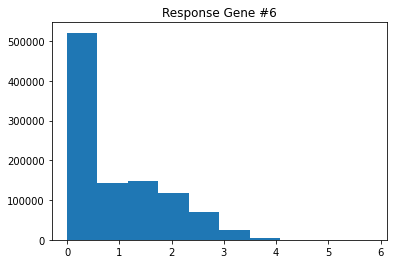

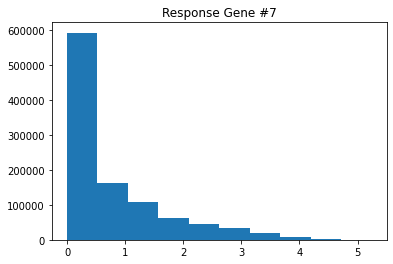

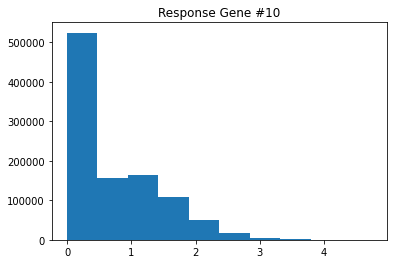

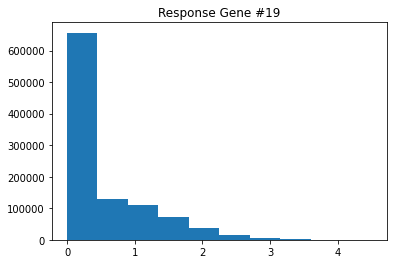

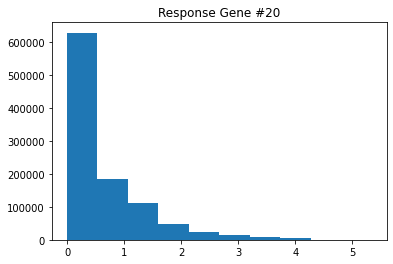

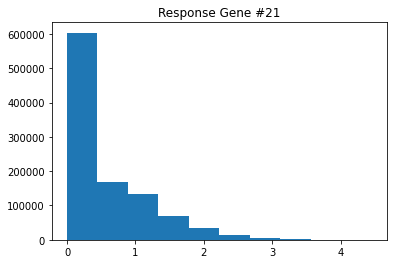

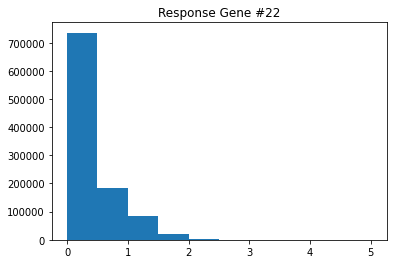

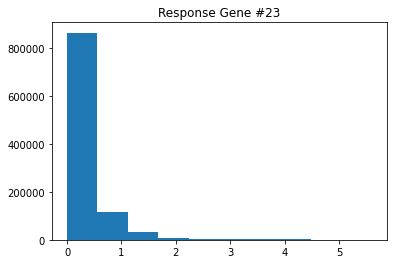

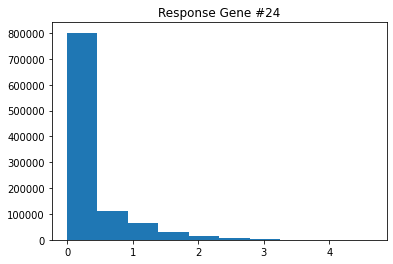

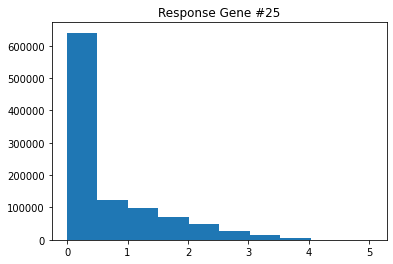

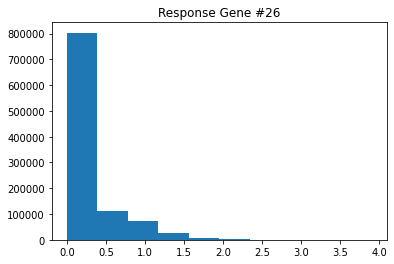

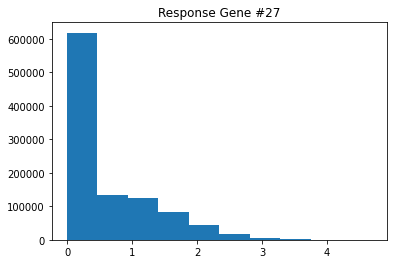

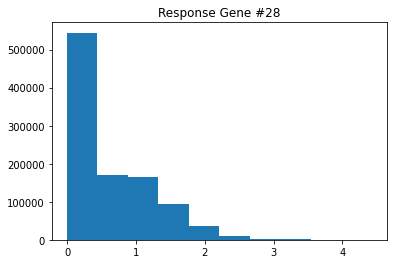

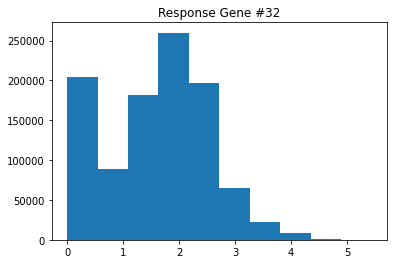

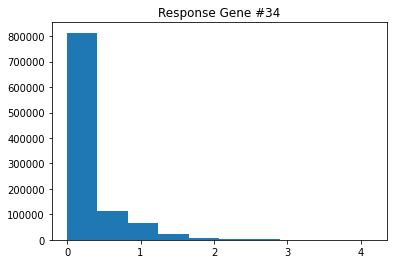

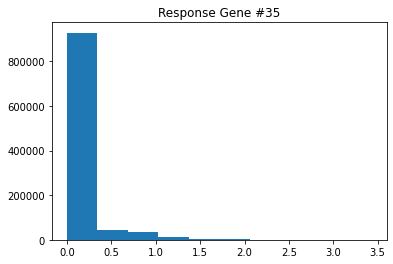

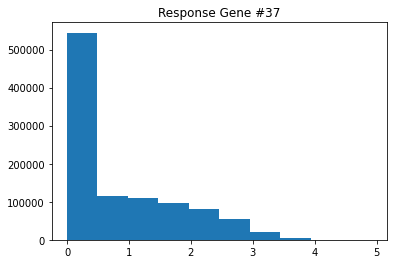

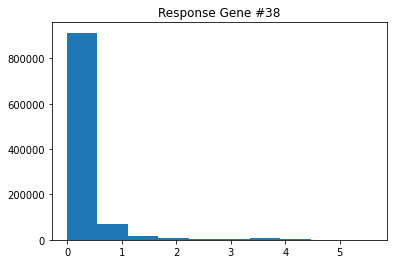

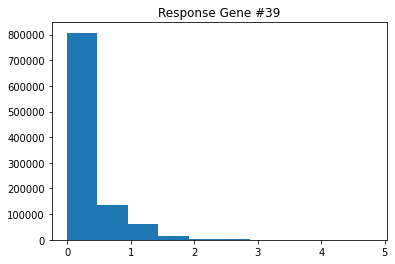

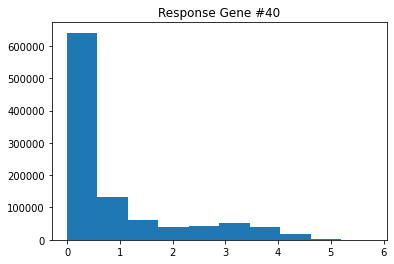

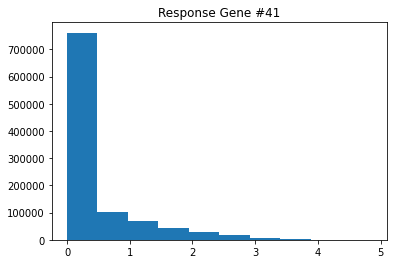

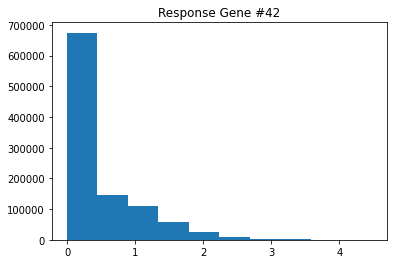

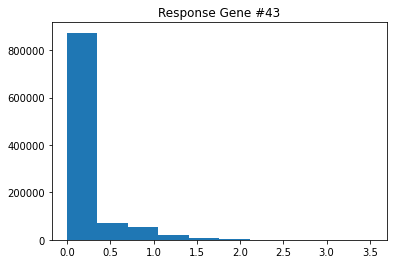

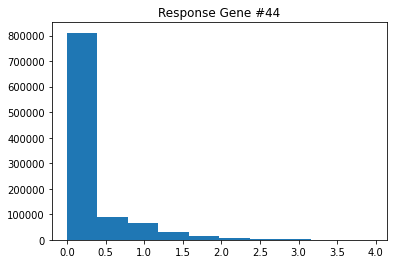

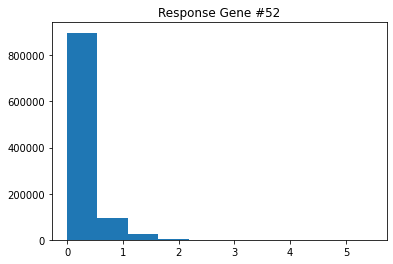

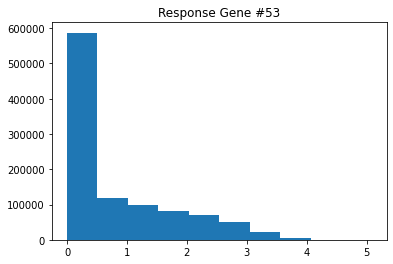

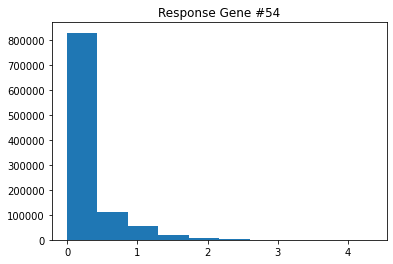

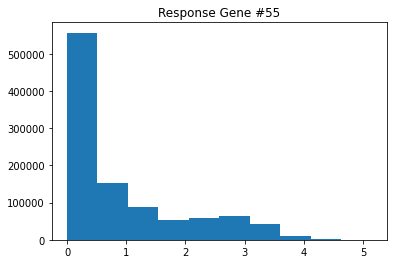

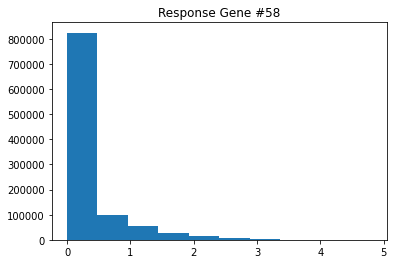

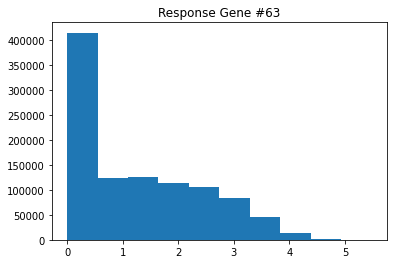

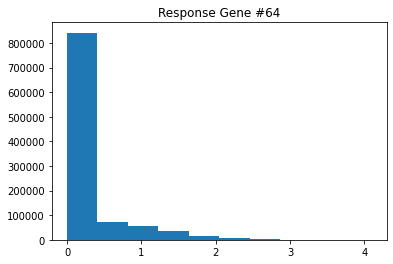

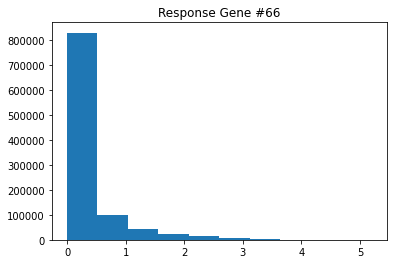

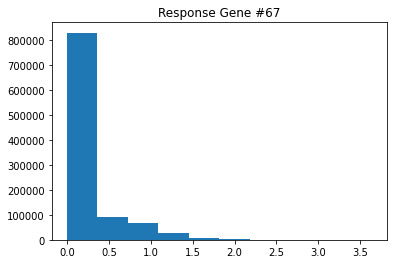

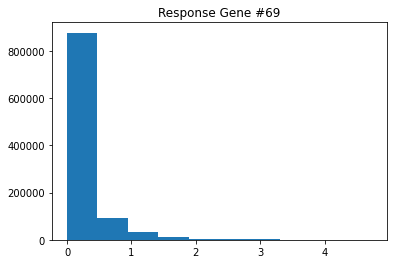

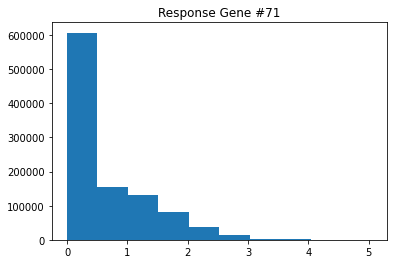

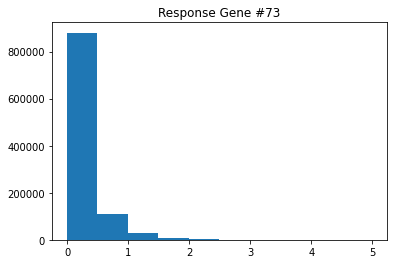

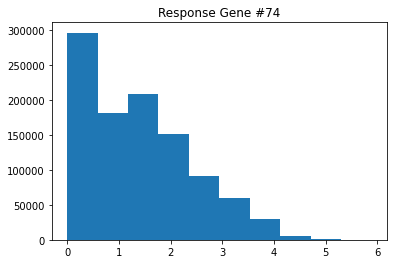

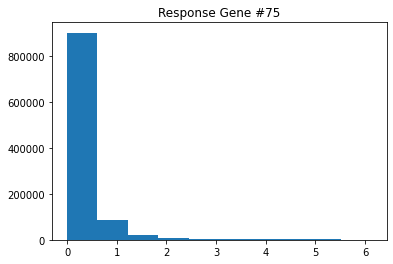

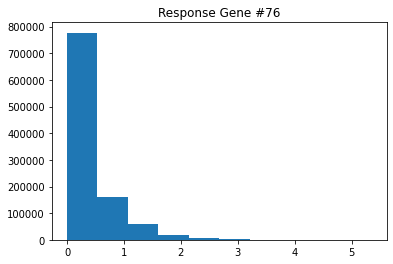

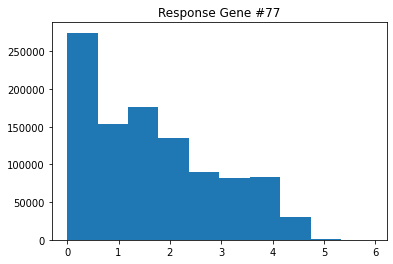

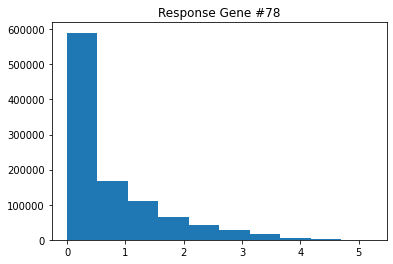

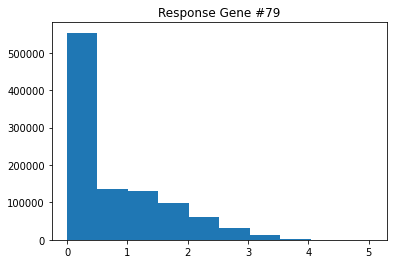

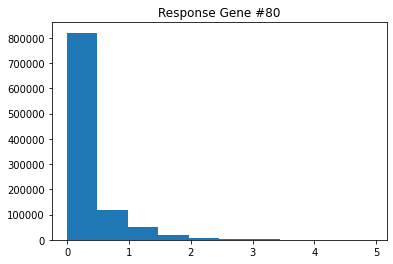

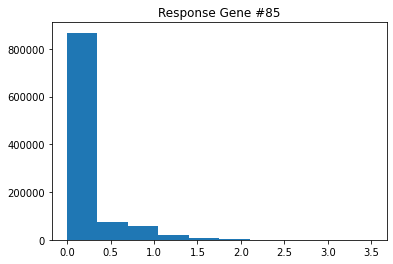

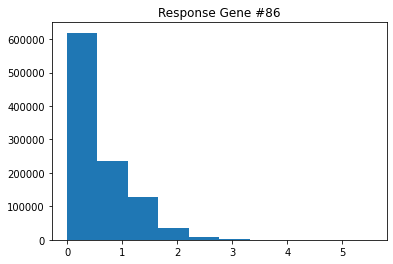

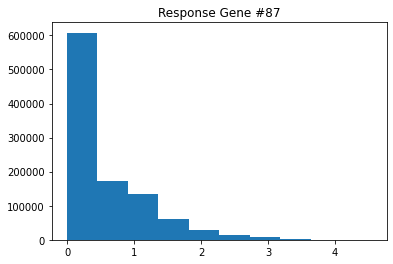

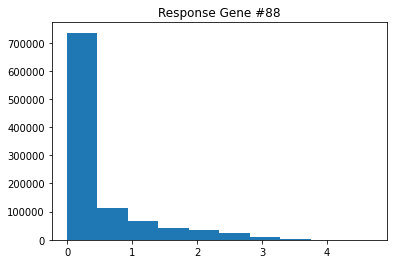

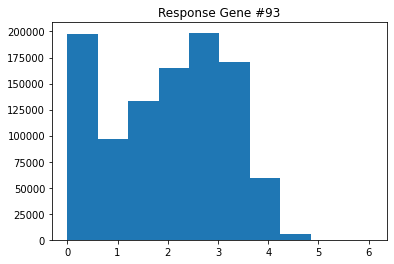

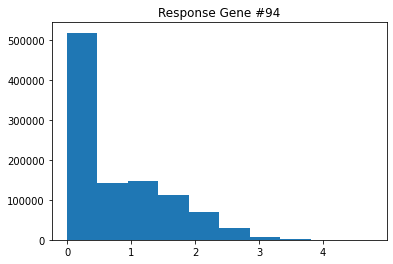

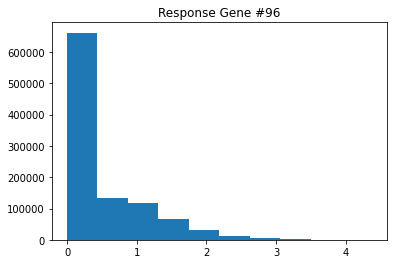

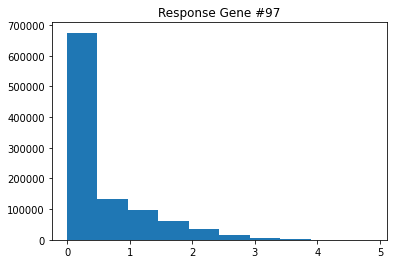

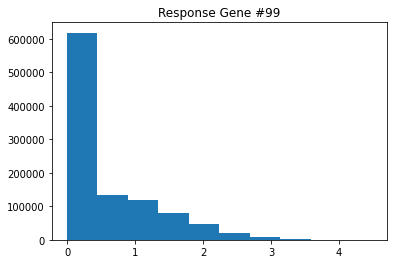

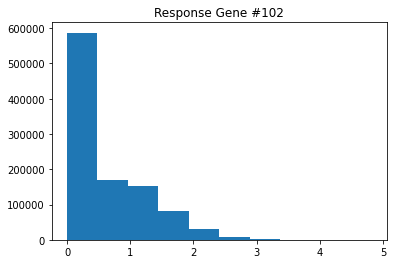

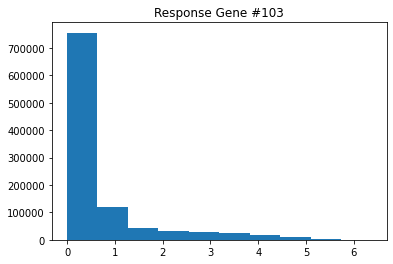

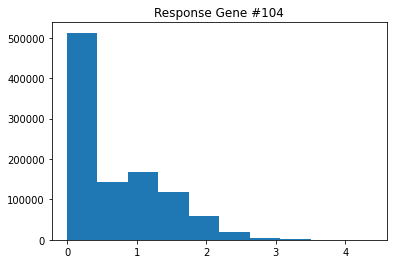

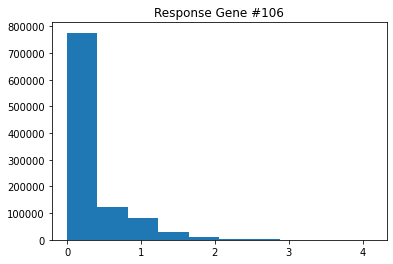

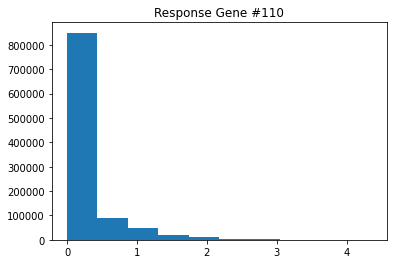

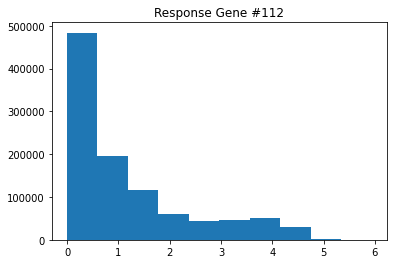

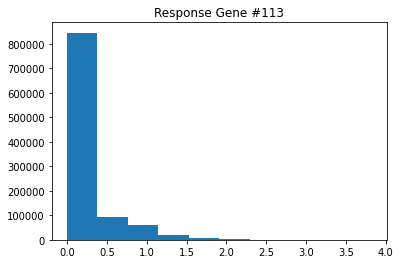

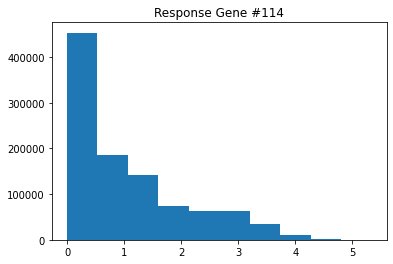

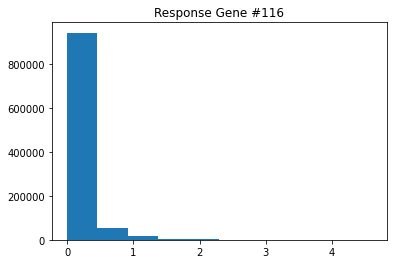

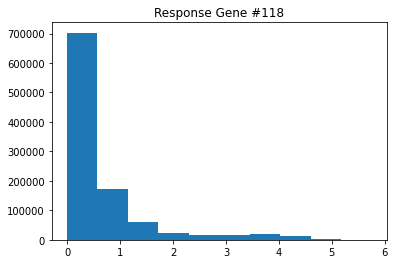

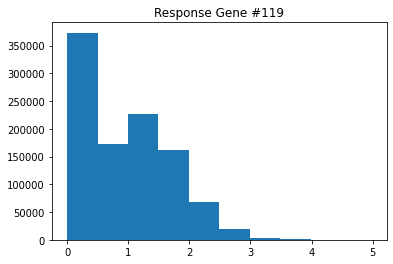

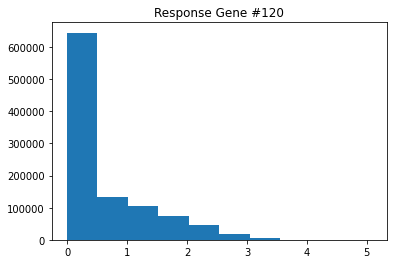

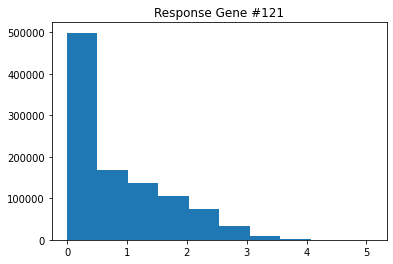

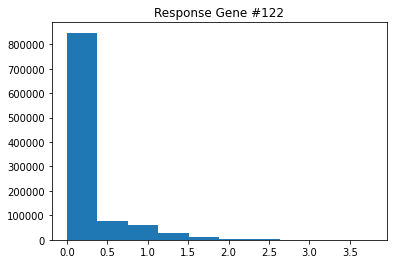

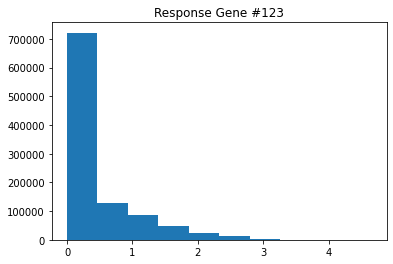

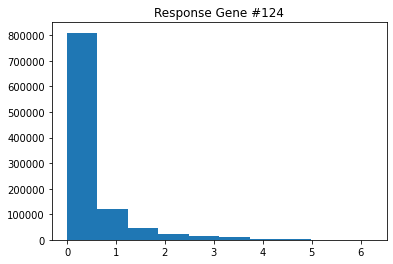

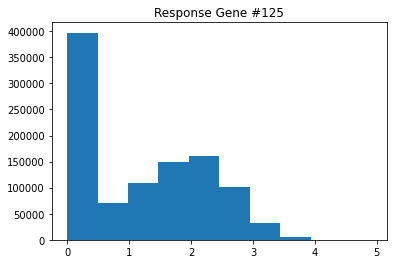

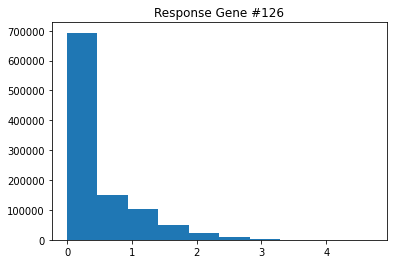

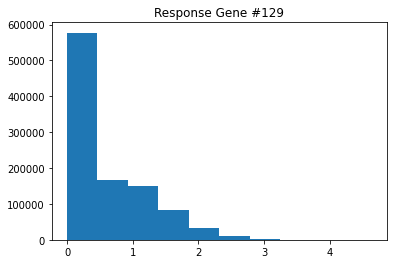

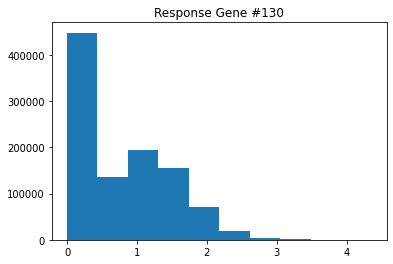

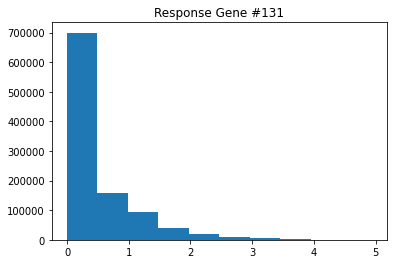

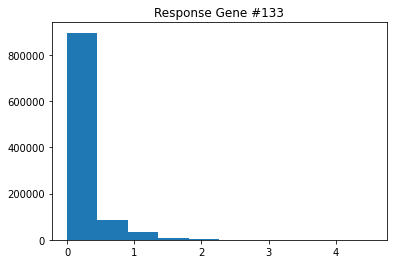

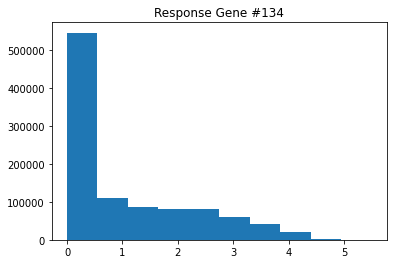

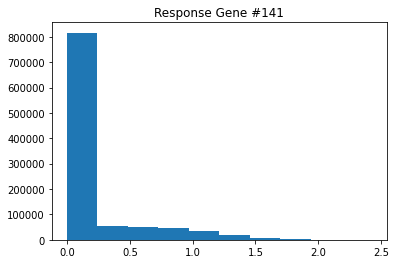

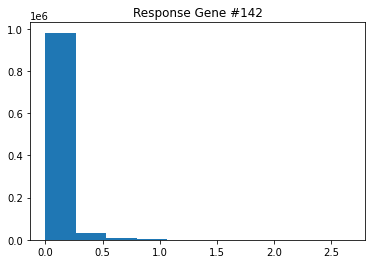

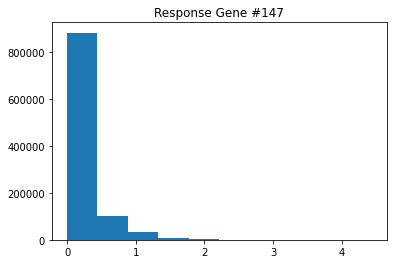

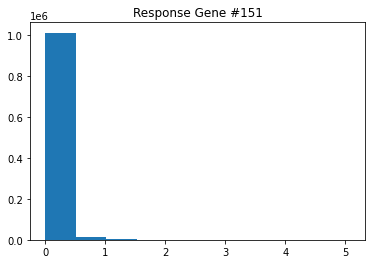

In [46]:
for i in test.response_genes:
    plt.figure()
    plt.hist(np.log1p(data.iloc[:, i]), bins=10)
    plt.title(f"Response Gene #{i}")
    plt.show()

In [35]:
zeros = {"min": (-1,1), "max": (-1,0)}
for i in test.response_genes:
    np.log1p(data.iloc[:, i])
    print(f"Response Gene #{i}: {np.mean(np.log1p(data.iloc[:, i]) == 0)}")
    if np.mean(np.log1p(data.iloc[:, i]) == 0) < zeros["min"][1]:
        zeros["min"] = (i, np.mean(np.log1p(data.iloc[:, i]) == 0))
    if np.mean(np.log1p(data.iloc[:, i]) == 0) > zeros["max"][1]:
        zeros["max"] = (i, np.mean(np.log1p(data.iloc[:, i]) == 0))
zeros

Response Gene #0: 0.8316044784831998
Response Gene #2: 0.41884111269370566
Response Gene #3: 0.49677384204668396
Response Gene #4: 0.7551097049369168
Response Gene #5: 0.4346381955308567
Response Gene #6: 0.48315023233007215
Response Gene #7: 0.5480790934068073
Response Gene #10: 0.4958184478638865
Response Gene #19: 0.6237527338672644
Response Gene #20: 0.5763332710673174
Response Gene #21: 0.5703557335325846
Response Gene #22: 0.6788980471820736
Response Gene #23: 0.797245312536484
Response Gene #24: 0.7618714051104832
Response Gene #25: 0.6045533970003347
Response Gene #26: 0.7716627361244075
Response Gene #27: 0.5873942450634724
Response Gene #28: 0.5134445949206498
Response Gene #32: 0.19308691557506558
Response Gene #34: 0.7781773180470264
Response Gene #35: 0.9001340665156716
Response Gene #37: 0.5144204201399428
Response Gene #38: 0.8617324740623127
Response Gene #39: 0.7595043235964851
Response Gene #40: 0.5803980744234556
Response Gene #41: 0.7230203298542197
Response Gene #4

{'min': (93, 0.1829443653147158), 'max': (116, 0.9072168258341701)}

In [42]:
test[0].edge_index[:, 4]

tensor([4, 4])